In [1]:
!pip install -q kaggle

In [2]:
#!/bin/bash
!kaggle datasets download shijo96john/heart-disease-prediction-image-dataset

Dataset URL: https://www.kaggle.com/datasets/shijo96john/heart-disease-prediction-image-dataset
License(s): apache-2.0
 99% 287M/290M [00:08<00:00, 45.1MB/s]
100% 290M/290M [00:08<00:00, 35.4MB/s]


In [3]:
!unzip /content/heart-disease-prediction-image-dataset.zip -d /content/ECG_Images

Archive:  /content/heart-disease-prediction-image-dataset.zip
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-1-_jpg.rf.40061f175a63955cf807d9a138be9303.jpg  
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-104-_jpg.rf.06cf0325d1c78189876befdab33ff95e.jpg  
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-115-_jpg.rf.acf8931a4187a677a7e177e8710ac8b6.jpg  
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-116-_jpg.rf.e2d8a2796a0501af56c2384d16dc3708.jpg  
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-125-_jpg.rf.f1e04ef7c78014429fb068eb24a47614.jpg  
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-139-_jpg.rf.584dc66f724c7959e2458016bce858f2.jpg  
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-159-_jpg.rf.bb2f8d262d1d91a25539ff603f7150d0.jpg  
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-196-_jpg.rf.a283d2d2c1de44f943d600eb7a0031c6.jpg  
  inflating: /content/ECG_Images/Dataset_ECG/test/AHB/HB-205-_jpg.rf.af125c8

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Define image size and batch size
img_width, img_height = 224, 224
batch_size = 32
num_classes = 5

In [3]:
# Define dataset paths
train_data_dir = '/content/ECG_Images/Dataset_ECG/train'
val_data_dir = '/content/ECG_Images/Dataset_ECG/valid'
test_data_dir = '/content/ECG_Images/Dataset_ECG/test'


In [4]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load Validation Data
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load Test Data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3993 images belonging to 5 classes.
Found 384 images belonging to 5 classes.
Found 191 images belonging to 5 classes.


In [5]:
# Load Pre-trained Densenet169 Model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Freeze some layers to retain pretrained features
for layer in base_model.layers[:50]:
    layer.trainable = False

# Add Custom Fully Connected Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
predictions = Dense(num_classes, activation='softmax')(x)

# Define Model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, None, None, 64) │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, None, None, 64) │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None,     │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None,     │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None,     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 32) │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, None, None, 96) │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 14,352,965 (54.75 MB)

 Trainable params: 13,849,477 (52.83 MB)

 Non-trainable params: 503,488 (1.92 MB)

In [6]:

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.6431 - loss: 0.9917 - val_accuracy: 0.5964 - val_loss: 1.0846
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 543ms/step - accuracy: 0.7654 - loss: 0.6367 - val_accuracy: 0.6589 - val_loss: 0.8968
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 541ms/step - accuracy: 0.8052 - loss: 0.5223 - val_accuracy: 0.8229 - val_loss: 0.5258
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 550ms/step - accuracy: 0.8309 - loss: 0.4284 - val_accuracy: 0.8333 - val_loss: 0.5131
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 545ms/step - accuracy: 0.8633 - loss: 0.3720 - val_accuracy: 0.7083 - val_loss: 0.7441
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 539ms/step - accuracy: 0.8721 - loss: 0.3302 - val_accur

In [7]:
# Evaluate Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Save the trained model
model.save("/content/Densenet169_ECG_Model.h5")


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7725 - loss: 0.6124



Test Accuracy: 0.8168
Test Loss: 0.5714


In [8]:
# Get Predictions
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get True Labels
test_true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Generate Classification Report
report = classification_report(test_true_labels, test_pred_labels, target_names=class_names)
print("\nClassification Report:\n", report)


6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step

Classification Report:
               precision    recall  f1-score   support

         AHB       0.77      0.67      0.72        51
    COVID-19       1.00      0.96      0.98        24
         HMI       0.71      0.81      0.76        21
          MI       0.33      0.25      0.29         4
      Normal       0.84      0.89      0.86        91

    accuracy                           0.82       191
   macro avg       0.73      0.71      0.72       191
weighted avg       0.81      0.82      0.81       191



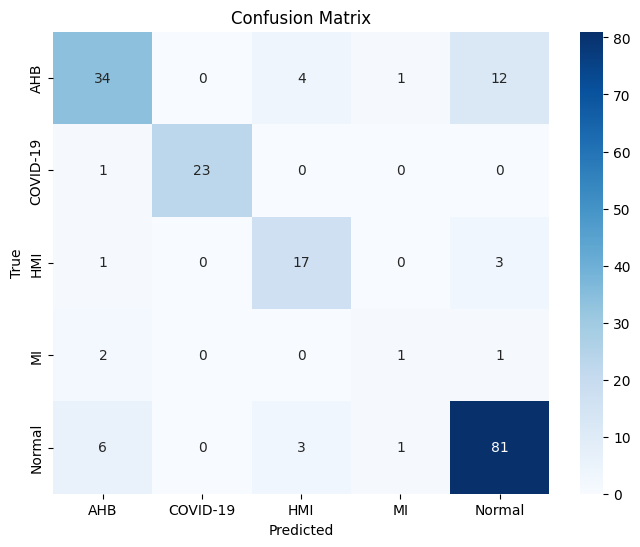

In [9]:
# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
# Load and Predict a Single Image
from tensorflow.keras.preprocessing import image

# Load the trained model
model_path = "/content/Densenet169_ECG_Model.h5"
model = tf.keras.models.load_model(model_path)

# Image Path (Update with a real image path)
img_path = "/content/ECG_Images/Dataset_ECG/test/HMI/PMI-138-_jpg.rf.491df6fbec2c32398cc834536ee513b3.jpg"

# Load and Preprocess Image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the image

# Make Predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# Print Prediction
print("Predicted class:", class_names[predicted_class])
print("Confidence:", predictions[0][predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted class: HMI
Confidence: 0.723308
